In [1]:
# Library and Modular Imports
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                             precision_score, recall_score)
import time
import torch
from torch.utils.data import DataLoader

# Self method Imports
from custom_dataset import CustomOCRDataset
from model import TextClassificationModel, train, evaluate
from preprocess import preprocess, collate_batch

#### Preprocess the data
This methods create the required csv, splits the data, builds the vocabulary and returns the training dataset

In [3]:
train_dataset = preprocess()

In [4]:
file = open('./vocab.pkl', 'rb')
# dump information to that file
vocab = pickle.load(file)
# close the file
file.close()

In [5]:
vocab_size = len(vocab)
model = TextClassificationModel(vocab_size)

In [6]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

# Hyperparameters
EPOCHS = 100  # epoch
LR = 0.1  # learning rate
BATCH_SIZE = 64  # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

train_iter = iter(train_dataset)
train_dataset = to_map_style_dataset(train_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
training_accuracy = []
validation_accuracy = []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    accu_train = train(train_dataloader, model, optimizer, criterion, epoch)
    accu_val,truth_dict = evaluate(valid_dataloader, model, criterion)
    print("-" * 59)
    print("Training Accuracy: ", accu_train)
    training_accuracy.append(accu_train)
    print(
        "| end of epoch {:3d} | time: {:5.2f}s | "
        "valid accuracy {:8.3f} |".format(
            epoch, time.time() - epoch_start_time, accu_val
        )
    )
    validation_accuracy.append(accu_val)
    print("-" * 59)

-----------------------------------------------------------
Training Accuracy:  0.25
| end of epoch   1 | time:  0.34s | valid accuracy    0.200 |
-----------------------------------------------------------
-----------------------------------------------------------
Training Accuracy:  0.15625
| end of epoch   2 | time:  0.44s | valid accuracy    0.240 |
-----------------------------------------------------------
-----------------------------------------------------------
Training Accuracy:  0.09375
| end of epoch   3 | time:  0.39s | valid accuracy    0.230 |
-----------------------------------------------------------
-----------------------------------------------------------
Training Accuracy:  0.203125
| end of epoch   4 | time:  0.40s | valid accuracy    0.260 |
-----------------------------------------------------------
-----------------------------------------------------------
Training Accuracy:  0.21875
| end of epoch   5 | time:  0.39s | valid accuracy    0.220 |
------------

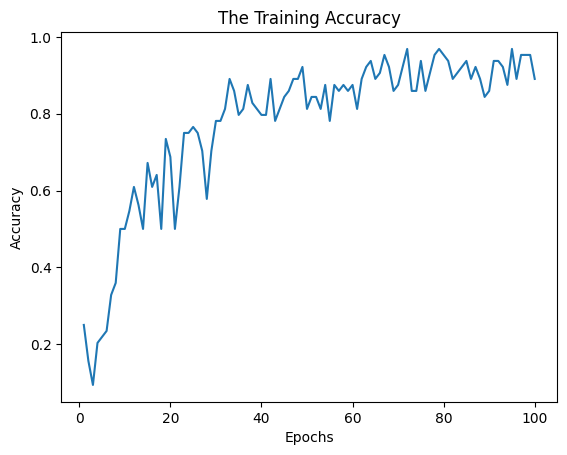

In [7]:
epochs=[i+1 for i in range(100)]

plt.plot(epochs, training_accuracy)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('The Training Accuracy')

# Show the plot
plt.show()

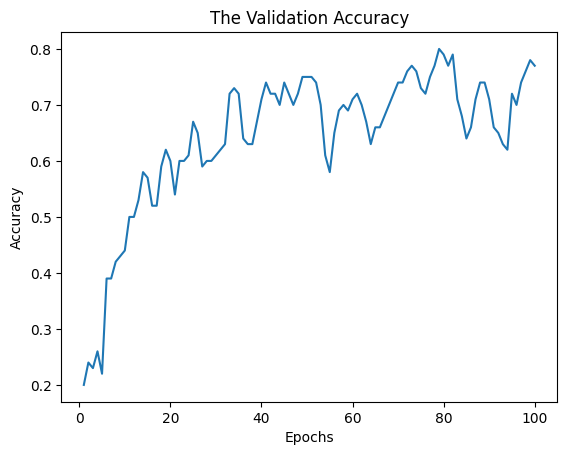

In [8]:
epochs=[i+1 for i in range(100)]

plt.plot(epochs, validation_accuracy)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('The Validation Accuracy')

# Show the plot
plt.show()

### Saving and Loading the Model

#### Save the trained model

In [9]:
torch.save(model,'./model/trained_model.pth')

#### Load the saved model

In [10]:
# Load the saved model
loaded_model = torch.load('./model/trained_model.pth')
loaded_model.eval()  # Set the model to evaluation mode if needed

TextClassificationModel(
  (embedding): EmbeddingBag(106256, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
  (relu2): ReLU(inplace=True)
  (fc3): Linear(in_features=5, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=5, bias=True)
)

### Testing the Model

#### Creating the Test Dataset and Data Loader

In [11]:
test_dataset = CustomOCRDataset('./test_dataset.csv')
test_iter = iter(test_dataset)
test_dataset = to_map_style_dataset(test_iter)

In [12]:
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

#### Evaluation of the Model

In [13]:
accuracy, truth_dict = evaluate(test_dataloader, model, criterion)

In [14]:
print("The accuracy is: ", accuracy_score(truth_dict["Predicted"],truth_dict["True"]))

The accuracy is:  0.754


In [ ]:
print("The Precision is: ", precision_score(truth_dict["Predicted"],truth_dict["True"]))

In [ ]:
print("The Recall is: ", recall_score(truth_dict["Predicted"],truth_dict["True"]))

In [15]:
print("The f1 score is: ", f1_score(truth_dict["Predicted"],truth_dict["True"], average=None))

The f1 score is:  [0.85585586 0.73366834 0.70769231 0.75294118 0.71028037]


<Axes: >

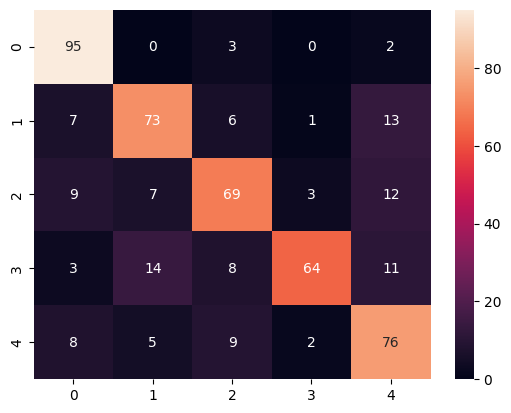

In [16]:
sns.heatmap(confusion_matrix(truth_dict["True"], truth_dict["Predicted"]), annot=True)

The model showed 75% accuracy in the test data

#### Verifying Evaluation in Loaded model

In [17]:
accuracy, truth_dict = evaluate(test_dataloader, loaded_model, criterion)

In [18]:
print("The accuracy is: ", accuracy_score(truth_dict["Predicted"],truth_dict["True"]))

The accuracy is:  0.754


In [ ]:
print("The Precision is: ", precision_score(truth_dict["Predicted"],truth_dict["True"]))

In [ ]:
print("The Recall is: ", recall_score(truth_dict["Predicted"],truth_dict["True"]))

In [19]:
print("The f1 score is: ", f1_score(truth_dict["Predicted"],truth_dict["True"], average=None))

The f1 score is:  [0.85585586 0.73366834 0.70769231 0.75294118 0.71028037]


<Axes: >

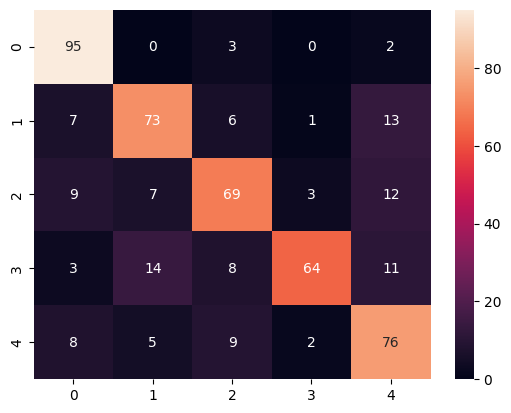

In [20]:
sns.heatmap(confusion_matrix(truth_dict["True"], truth_dict["Predicted"]), annot=True)

The loaded model also showed the same metrics, this implies the model was saved correctly without the loss of information